In [13]:
!pip install SimpleITK numpy matplotlib scikit-image plotly scipy nbformat

### Utils

In [14]:
# imports

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import plotly.graph_objects as go
from scipy.ndimage import label
from scipy.spatial.distance import cdist
import os

In [15]:
def world_to_voxel(world_coords, origin, spacing, direction):
    direction_matrix = np.array(direction).reshape(3, 3)
    voxel_coords = np.linalg.inv(direction_matrix @ np.diag(spacing)) @ (world_coords - origin)
    return tuple(map(int, np.round(voxel_coords)))

def voxel_to_world(voxel_coords, origin, spacing, direction):
    direction_matrix = np.array(direction).reshape(3, 3)
    world_coords = (direction_matrix @ np.diag(spacing) @ voxel_coords) + origin
    return world_coords



## Step 1 & 2: Load Data

We load the CT scan and its corresponding segmentation masks from the provided NRRD files. We also extract key metadata from the CT image, such as its **origin**, **spacing**, and **direction cosine matrix**, which are crucial for converting between world and voxel coordinate systems.

In [16]:
ct_path = 'ct_scan.nrrd'
masks_path = 'ct_masks.nrrd'

# Load Images
ct_image = sitk.ReadImage(ct_path, sitk.sitkFloat32)
masks_image = sitk.ReadImage(masks_path, sitk.sitkUInt8)

# Extract Metadata
origin = np.array(ct_image.GetOrigin())
spacing = np.array(ct_image.GetSpacing())
direction = np.array(ct_image.GetDirection())

# Convert to NumPy Arrays
ct_array = sitk.GetArrayFromImage(ct_image)       # Shape: (Z, Y, X)
masks_array = sitk.GetArrayFromImage(masks_image)

print(f"CT Image Loaded. Shape: {ct_array.shape}, Voxel Spacing: {spacing}")
print(f"Masks Loaded. Shape: {masks_array.shape}")

CT Image Loaded. Shape: (393, 512, 512), Voxel Spacing: [0.35156301 0.35156301 0.40000013]
Masks Loaded. Shape: (393, 512, 512)


## Step 3: Crop Image and Masks

The task requires cropping the image based on an axis-aligned bounding box defined by two points in the world coordinate system.We first need a function to convert these world coordinates into image-space (voxel) coordinates. Then, we use NumPy slicing to perform the crop.

In [17]:
# Bounding Box in World Coordinates
p1_world = np.array([4.96, 155.48, 1796.2])
p2_world = np.array([150.52, 32.35, 1899.4])

# Convert to Voxel Coordinates
v1 = world_to_voxel(p1_world, origin, spacing, direction)
v2 = world_to_voxel(p2_world, origin, spacing, direction)

# Slicing Indices
x_start, x_end = min(v1[0], v2[0]), max(v1[0], v2[0])
y_start, y_end = min(v1[1], v2[1]), max(v1[1], v2[1])
z_start, z_end = min(v1[2], v2[2]), max(v1[2], v2[2])

# Cropping
cropped_ct_array = ct_array[z_start:z_end, y_start:y_end, x_start:x_end]
cropped_masks_array = masks_array[z_start:z_end, y_start:y_end, x_start:x_end]

#debug
print(f"Original shape: {ct_array.shape}")
print(f"Cropped shape:  {cropped_ct_array.shape}")

Original shape: (393, 512, 512)
Cropped shape:  (258, 350, 414)


## Step 4: Create a Spherical Mask

Here, we generate a spherical mask with a **3mm radius** centered around a given point in world coordinates. The process involves converting the world center to the *cropped* image's voxel space, creating a coordinate grid, and then using the sphere equation to create the binary mask. The final mask is saved as `spherical_mask.nrrd`.

In [18]:
# Sphere Parameters Mask
sphere_center_world = np.array([62.35, 69.91, 1857.00])
sphere_radius_mm =3.0

# Cropped Image Origin
cropped_origin_voxel = np.array([x_start, y_start, z_start])
cropped_origin_world =voxel_to_world(cropped_origin_voxel, origin, spacing, direction)

# Spherical Mask
sphere_center_voxel = world_to_voxel(sphere_center_world, cropped_origin_world, spacing, direction)
z, y, x = np.ogrid[:cropped_ct_array.shape[0], :cropped_ct_array.shape[1],:cropped_ct_array.shape[2]]
dist_sq = ((x - sphere_center_voxel[0])*spacing[0])**2 + ((y - sphere_center_voxel[1])*spacing[1])**2 + ((z - sphere_center_voxel[2])*spacing[2])**2
spherical_mask_array = (dist_sq <= sphere_radius_mm**2).astype(np.uint8)

# Save the Mask
spherical_mask_image = sitk.GetImageFromArray(spherical_mask_array)
spherical_mask_image.SetOrigin(cropped_origin_world)
spherical_mask_image.SetSpacing(spacing)
spherical_mask_image.SetDirection(direction)
sitk.WriteImage(spherical_mask_image, 'spherical_mask.nrrd')

print(f"Spherical mask created with center at voxel {sphere_center_voxel}.")

Spherical mask created with center at voxel (163, 106, 152).


## Step 5 & 6: 3D Mesh Conversion and Plotting

This section covers two tasks:
1.  **Convert masks into 3D meshes**. We use the `marching_cubes` algorithm from `scikit-image`.
2.  **Generate plots**. We create three 2D plots for the middle axial, sagittal, and coronal slices with semi-transparent mask overlays. We also generate an interactive 3D plot of the meshes.

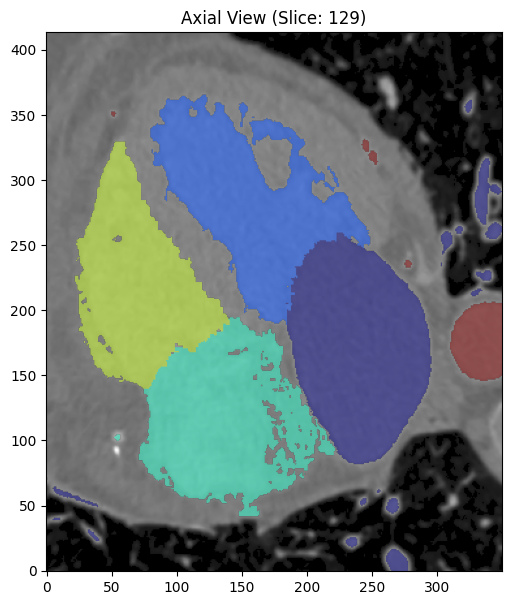

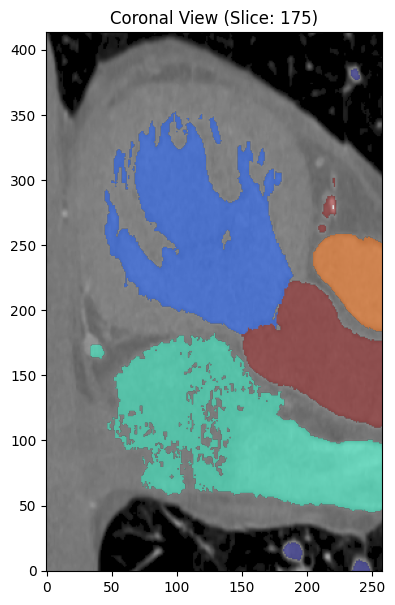

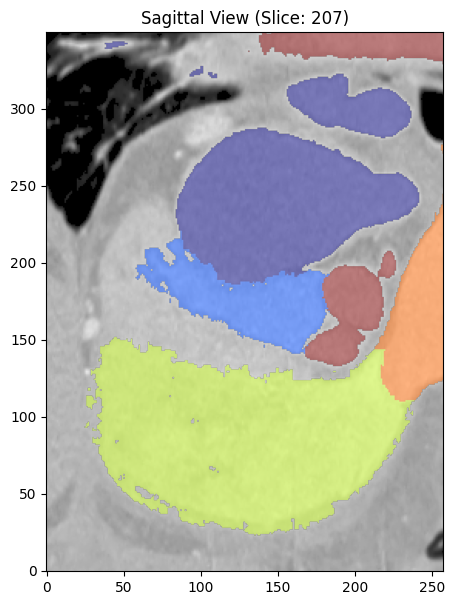

In [20]:
# 2D Plotting
# We create a dict
mid_z, mid_y, mid_x = [dim // 2 for dim in cropped_ct_array.shape]
views = {'Axial': (mid_z, 'Z'), 'Coronal': (mid_y, 'Y'), 'Sagittal': (mid_x, 'X')}

for view_name, (slice_idx, axis) in views.items():
    plt.figure(figsize=(7, 7))
    if axis =='Z':
        img_slice, mask_slice = cropped_ct_array[slice_idx, :, :], cropped_masks_array[slice_idx, :, :]
    elif axis == 'Y':
        img_slice, mask_slice = cropped_ct_array[:, slice_idx, :], cropped_masks_array[:, slice_idx, :]
    else:
        img_slice, mask_slice = cropped_ct_array[:, :, slice_idx], cropped_masks_array[:, :, slice_idx]

    plt.imshow(img_slice.T, cmap='gray', origin='lower')
    masked_overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
    plt.imshow(masked_overlay.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title(f"{view_name} View (Slice: {slice_idx})")
    plt.show()

# 3D Meshing and Plotting
# Labels
# labels_info = {

    #1: ('Left Atrium','red'), 2: ('Left Ventricle', 'blue'), 3: ('Right Atrium', 'magenta'),
    #4: ('Right Ventricle', 'yellow'), 5: ('Pulmonary Artery', 'green'), 6: ('Aorta', 'cyan')
# }
#fig_3d = go.Figure()

#for label_id, (name, color) in labels_info.items():
#    mask = cropped_masks_array == label_id
#    if np.any(mask):
#        verts, faces, _, _ = measure.marching_cubes(mask, level=0.5, spacing=spacing)
#        verts += cropped_origin_world
#        fig_3d.add_trace(go.Mesh3d(
#            x=verts[:, 0], y=verts[:, 1], z=verts[:, 2],
#            i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
#            color=color, opacity=0.5, name=name
#        ))

#fig_3d.update_layout(title='3D Models of Heart Structures', scene=dict(aspectratio=dict(x=1, y=1, z=1)))
#fig_3d.show()

## Step 7 & 8: Boolean Mask Operations

Now we create two new masks using boolean logic as specified:
* **Mask 1 (Step 7):** Threshold the image, find the largest connected component, and then subtract the right heart chamber masks.
* **Mask 2 (Step 8):** Create a simple union of the left heart chamber and aorta masks.

In [21]:
threshold_mask = (cropped_ct_array >= 1305) & (cropped_ct_array <= 2562)
labeled_array, num_features = label(threshold_mask)

np.shape

if num_features > 0:
    component_sizes = np.bincount(labeled_array.ravel())[1:]
    largest_component_label = np.argmax(component_sizes) + 1
    largest_component_mask = (labeled_array == largest_component_label)
else:
    largest_component_mask = np.zeros_like(threshold_mask)

subtraction_mask = np.isin(cropped_masks_array, [3, 4, 5]) # RA, RV, PA
mask_step7 = largest_component_mask & ~subtraction_mask

# New Mask from Union
mask_step8 = np.isin(cropped_masks_array, [1, 2, 6]) # LA, LV, Aorta

#debug
print(f"Mask from Step 7 created with {np.sum(mask_step7)} voxels.")
print(f"Mask from Step 8 created with {np.sum(mask_step8)} voxels.")

Mask from Step 7 created with 3328725 voxels.
Mask from Step 8 created with 4557266 voxels.


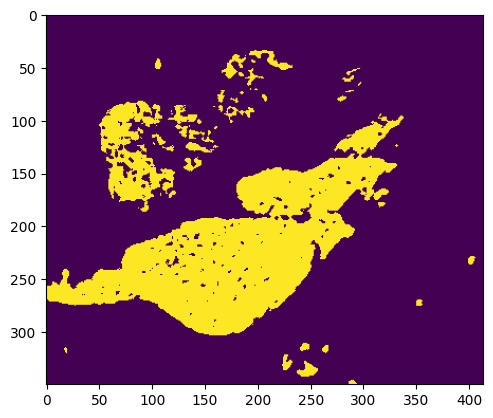

In [22]:
plt.imshow(labeled_array[150] == 8)

## Step 9: Calculate and Print Metrics

Finally, we implement functions to calculate the Dice score and Hausdorff distance. We then use these to compare the two masks generated in the previous steps and print the results, along with the volume of each mask in $mm^3$.

In [23]:
from scipy.ndimage import binary_erosion
from scipy.spatial import KDTree
import numpy as np

def get_surface(mask):
    eroded_mask = binary_erosion(mask)
    surface_mask = mask & ~eroded_mask
    return surface_mask

def dice_score(mask1, mask2):
    intersection = np.sum(mask1 & mask2)
    total = np.sum(mask1) + np.sum(mask2)
    return 2. * intersection / total if total > 0 else 1.0

def hausdorff_distance(mask1, mask2, spacing):

    #Get the surface points for each mask
    surface1 = get_surface(mask1)
    surface2 = get_surface(mask2)

    coords1 = np.argwhere(surface1)
    coords2 = np.argwhere(surface2)

    if coords1.shape[0] == 0 or coords2.shape[0] == 0:
        return np.inf

    # Convert coordinates to real-world units (mm)
    coords1_mm = coords1 * spacing
    coords2_mm = coords2 * spacing

    # Build a k-d tree for each point set for fast lookups
    tree1 = KDTree(coords1_mm)
    tree2 = KDTree(coords2_mm)

    # 3 Find the nearest neighbor distances for each point
    # For each point in surface 1, find its closest point in surface 2
    dist_1_to_2, _ = tree2.query(coords1_mm, k=1)

    # same
    dist_2_to_1, _ = tree1.query(coords2_mm, k=1)

    # The Hausdorff distance is the maximum of all these minimum distances
    hausdorff_dist = max(np.max(dist_1_to_2), np.max(dist_2_to_1))

    return hausdorff_dist

# Calculate Metrics
final_dice_score = dice_score(mask_step7, mask_step8)
final_hausdorff_dist = hausdorff_distance(mask_step7, mask_step8, spacing)

# Calculate Volumes
voxel_volume_mm3 = np.prod(spacing)
volume_mask7_mm3 = np.sum(mask_step7)*voxel_volume_mm3
volume_mask8_mm3 = np.sum(mask_step8)*voxel_volume_mm3

# Results
print("\n--- Final Metrics ---")
print(f"Mask from Step 7 (Threshold) Volume: {volume_mask7_mm3:.2f} mm^3")
print(f"Mask from Step 8 (Union) Volume:     {volume_mask8_mm3:.2f} mm^3")
print("---------------------------------")
print(f"Dice Score:                          {final_dice_score:.4f}")
print(f"Hausdorff Distance:                  {final_hausdorff_dist:.2f} mm")


--- Final Metrics ---
Mask from Step 7 (Threshold) Volume: 164567.62 mm^3
Mask from Step 8 (Union) Volume:     225305.01 mm^3
---------------------------------
Dice Score:                          0.8381
Hausdorff Distance:                  38.72 mm
